Below we right a program to calculate hurst exponent from time series data,
1.We will start with a program that computes hurst exponent using all the time series data.
2.We will then next write a program that computes hurst exponent for each individual month and we average the monthly values to get a hurst exponent.


Training set score: 0.96
Test set score: 0.96


Text(0, 0.5, 'log(R/s)')

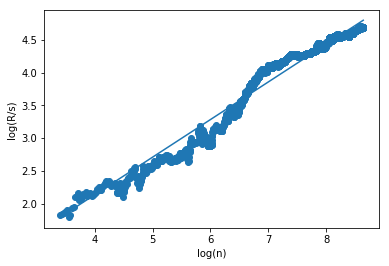

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math as mh
data_raw=pd.read_csv('AMZN.csv')
rdata=data_raw['log return']
data=data_raw['Close']
dt=2
#def rescaled_analysis(data):
N=len(data)
n=30
xval=np.linspace(n,N,(N-n+1))
xval=xval.reshape(-1,1)
logx=np.log(xval)
yval=[0]*len(xval)
for t in range(n,N+1):
    tpx=rdata[0:t]
    Y=tpx-np.mean(tpx)
    Z=np.cumsum(Y)
    R=max(Z)-min(Z)
    S=np.std(tpx)
    yval[t-n]=(R/S)    
logy=np.log(yval)
logy=np.transpose(logy)
X_train, X_test, y_train, y_test = train_test_split(logx,logy,random_state=0)
lr = LinearRegression().fit(logx,logy)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
hurst_lr=lr.coef_[0] 
hurst_lr
#return hurst  
#rescaled_analysis(data)
plt.scatter(logx,logy)
plt.plot(logx,logx*hurst_lr+lr.intercept_)
plt.xlabel('log(n)')
plt.ylabel('log(R/s)')

In [41]:
#calculating 2 day log returns
sum2=0
sum3=0
sum4=0
a=0
b=0
logret=[]
for k in range(2,round(len(data)/2+1)):
    a=2*(k-1)
    b=2*(k-1)-2
    sum2=data[a]
    sum3=data[b]
    sum4=np.log(sum2/sum3)
    logret.append(sum4)


computed hurst exponent value

In [42]:
hurst_lr

0.5741805062744748

compute standard deviation

In [43]:
standard_dev=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
std_lr=standard_dev(logret,dt,hurst_lr)    
std_lr

0.0352460214540058

computing dirft(mean) 

In [100]:
mean_frac=lambda rdata,dt,standard_dev:np.mean(rdata2)/dt+(standard_dev**2)/2
mean_frac(rdata,dt,standard_dev(rdata,dt,hurst_lr))

0.0005366107332073849

we build algorithm to compute hurst exponent for 30 days,  
we then have a time series of hurst exponent numbers for varous months from jan 1 1920 to 25 october 2019

Text(0, 0.5, 'Hurst value')

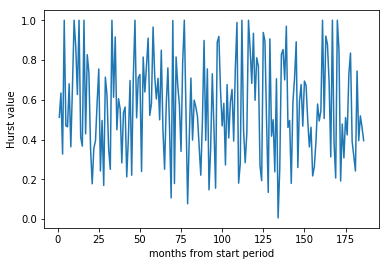

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mh
data_raw=pd.read_csv('AMZN.csv')
rdata=data_raw['log return']
data=data_raw['Close']
dt=2

#function to comupte hurst exponent for a given period.
#note the data points must be not less than n=11
def rescaled_analysis(data):
    N=len(data)
    n=11
    xval=np.linspace(n,N,(N-n+1))
    logx=np.log(xval)
    yval=[0]*len(xval)
    for t in range(n,N+1):
        tpx=data[0:t]
        Y=tpx-np.mean(tpx)
        Z=np.cumsum(Y)
        R=max(Z)-min(Z)
        S=np.std(tpx)
        yval[t-n]=(R/S)    
    logy=np.log(yval)
    logy=np.transpose(logy)
    hurst=np.polyfit(logx,logy,1)[0]
    return hurst 

#get number of items in our dataset
N=len(data)
#pick data period of 30 days
m=30
#compute the number of 30 day peroids that canbe got from data
l=(round(N/m)-1)*m
i=0
maza=[0]*(round(N/m)-2)

#loop to compute hurst exponent for each period 
for k in range(m,l,m):
    zdata=rdata[i*m:k]
    maza[i]=rescaled_analysis(zdata)
    if maza[i]>1:
        maza[i]=1
    if maza[i]<0:
        maza[i]=0
    i=i+1
average=np.mean(maza)

#hurst is then comupted as average of all months
hurst_average_monthly=average
xvex=np.linspace(1,len(maza),len(maza))
plt.plot(xvex,maza)
plt.xlabel("months from start period")
plt.ylabel('Hurst value')

compute volatility 


In [45]:
standard_dev=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
standard_dev_monthly_av=standard_dev(logret,dt,average) 
standard_dev_monthly_av

0.035466743853942044

In [46]:
hurst_average_monthly

0.5651740377930863

we compute the drift(mean)

In [17]:
mean_frac=lambda rdata,dt,standard_dev:np.mean(rdata2)/dt+(standard_dev**2)/2
mean_frac(rdata,dt,standard_dev(logret,dt,hurst_average_monthly))

0.0018445915079336422

From the plots of our monthly hurst exponent computstions we notice that although there are periods of volatility

in the plot of monthly hurst exponent values there appears that the values are oscilating about amean value and showing signs
of stationary.

We model our hurst exponent monthly data as autoregressive model.

In [47]:
#training Autoregresive model to predict next peorid hurst exponent
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
model=ARIMA(maza,order=(2,0,0))
result=model.fit()
pred=result.predict(start=len(maza),end=len(maza))
predmaz=maza.append(pred)
hurst_AR=pred[0]
print("hurst exponent predicted=",pred[0])
result.summary()

hurst exponent predicted= 0.585845162467228


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  186
Model:                     ARMA(2, 0)   Log Likelihood                  -3.325
Method:                       css-mle   S.D. of innovations              0.246
Date:                Mon, 10 Aug 2020   AIC                             14.650
Time:                        01:22:33   BIC                             27.553
Sample:                             0   HQIC                            19.879
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5654      0.015     36.676      0.000       0.535       0.596
ar.L1.y       -0.0380      0.073     -0.523      0.601      -0.180       0.104
ar.L2.y       -0.1353      0.072     -1.869      0.063      -0.277       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1404           -2.7151j            2.7187           -0.2582
AR.2           -0.1404           +2.7151j            2.7187            0.2582
-----------------------------------------------------------------------------
"""

In [48]:
hurst_AR

0.585845162467228

In [49]:
standard_dev_AR=lambda rdata,dt,hurst:np.sqrt(np.var(rdata)/dt**(2*hurst))
std_AR=standard_dev_AR(logret,dt,pred[0]) 
std_AR

0.034962194927473385

when we check the model parameters we notice that the coffients are greater than twice the standard error and are both significant.
notice that the predicted value is close to the value got by averaging all the monthly hurst exponent values.

In the next section we will try to price our options using various hurst exponent and volatility values we obtained using the 
models we have explore above

In [50]:
#Fractional BlackScholes model pricing
from scipy.stats import norm

Φ = norm.cdf

d1 = lambda S,K,r,τ,σ,H : (np.log(S/K) + r*τ + 0.5*(σ**2)*(τ**(2*H)))/(σ*np.sqrt(τ**(2*H)))

d2 = lambda S,K,r,τ,σ,H : d1(S,K,r,τ,σ,H) - σ*(np.sqrt(τ**(2*H)))
                                                                                             
def fbsm(S,K,r,τ,σ,H):       
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(d1(S,K,r,τ,σ,H)) - (K*np.exp(-r*τ))*Φ(d2(S,K,r,τ,σ,H))

In [51]:
#Standard Black-Scholes model pricing
Φ = norm.cdf

dstock1 = lambda S,K,r,τ,σ: ((np.log(S/K) + (r + 0.5*σ**2)*τ))/(σ*np.sqrt(τ))

dstock2 = lambda S,K,r,τ,σ: dstock1(S,K,r,τ,σ) - (σ*np.sqrt(τ))

def sbsm(S,K,r,τ,σ):    
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(dstock1(S,K,r,τ,σ)) - (K*np.exp(-r*τ))*Φ(dstock2(S,K,r,τ,σ))

In [54]:
#here we try to price our call options using historical data by using our Autoregressive model (AR) generated
#from the monthly hurst exponent data
options_data=pd.read_csv('AMZN_options.csv')
fsbsm_price_AR=[0]*len(options_data['ticker'])
for i in range(0,len(options_data['ticker'])):
    fsbsm_price_AR[i]=fbsm(options_data['stkPx'][i],options_data['strike'][i],options_data['iRate'][i],options_data['duration'][i]/30,std_AR,hurst_AR)

In [55]:
#here we try to price our call options using historical data by using our Autoregressive model (AR)
#from the monthly hurst exponent data
fsbsm_price_monthly_av=[0]*len(options_data['ticker'])
for i in range(0,len(options_data['ticker'])):
    fsbsm_price_monthly_av[i]=fbsm(options_data['stkPx'][i],options_data['strike'][i],options_data['iRate'][i],options_data['duration'][i]/30,standard_dev_monthly_av,hurst_average_monthly)


In [56]:
#here we try to price our call options using historical data by using our a linear model for our historical stock data
fsbsm_price_lr=[0]*len(options_data['ticker'])
for i in range(0,len(options_data['ticker'])):
    fsbsm_price_lr[i]=fbsm(options_data['stkPx'][i],options_data['strike'][i],options_data['iRate'][i],options_data['duration'][i]/30,std_lr,hurst_lr)

In [57]:
sbsm_price=[0]*len(options_data['ticker'])
a=np.std(rdata)
for i in range(0,len(options_data['ticker'])):
    sbsm_price[i]=sbsm(options_data['stkPx'][i],options_data['strike'][i],options_data['iRate'][i],options_data['duration'][i]/30,a)

In [58]:
a

0.037050099955682814

In [59]:
from sklearn.metrics import mean_squared_error as MSE

error_AR=MSE(options_data['cValue'],fsbsm_price_AR)
error_AR

191.85859516852207

In [60]:
error_monthly_av=MSE(options_data['cValue'], fsbsm_price_monthly_av)
error_monthly_av

192.52817453149828

In [61]:
error_lr=MSE(options_data['cValue'],   fsbsm_price_lr)
error_lr

192.18712326257992

In [62]:
sbsm_price=MSE(options_data['cValue'],   sbsm_price)
sbsm_price

196.78141226741099

In [63]:
sumdata=([error_AR,error_monthly_av,error_lr,sbsm_price])
heading=(["error_AR","error_monthly_av","error_lr","sbsm_price"])

In [64]:
sumdata=pd.DataFrame(sumdata,heading, columns= ["means square error"])
sumdata

,means square error
error_AR,191.858595
error_monthly_av,192.528175
error_lr,192.187123
sbsm_price,196.781412


In [261]:
volatility_cal=np.log(np.std(rdata))+(hurst_AR-0.5)*np.log(len(data))
volatility_cal=np.exp(volatility_cal)
volatility_cal

0.04263926029341843